In [17]:
# import pydrake
# import underactuated
# except ImportError:
#     !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
#     from jupyter_setup import setup_underactuated
#     setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).  
from jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

In [18]:
# general imports
import os
import numpy as np
import scipy as sp

# plotting/animation imports
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation, writers
from matplotlib.patches import Rectangle, Circle, Arrow
from matplotlib.transforms import Affine2D
rcParams['figure.figsize'] = (8, 5)
from IPython.display import HTML, display

# pydrake imports
from pydrake.all import (VectorSystem, DiagramBuilder, SymbolicVectorSystem, LogOutput, 
                         PlanarSceneGraphVisualizer, Variable, SceneGraph, Parser, 
                         MultibodyPlant, AddMultibodyPlantSceneGraph, Simulator, 
                         plot_system_graphviz, MathematicalProgram, SnoptSolver,
                         PiecewisePolynomial,AutoDiffXd)

from pydrake.solvers.mathematicalprogram import GetInfeasibleConstraints

from pydrake.symbolic import if_then_else, logical_and, logical_or
from pydrake.common.containers import EqualToDict
from pydrake.symbolic import Expression, abs, cos, sin, tan, sqrt
import pydrake.symbolic as sym

import os 
import datetime
import pytz
from pprint import pprint
import time
import json

# Dynamics

In [19]:
def drag_coeff_from_angle(angle, C_side, C_front):
    '''
    Takes a weighted average of the side drag coefficient and front/back drag
    coefficient. The weighting corresponds to angle = boat_heading for the
    y-direction coefficients, with the x-direction just being a 90 deg shift

    Currently assumes boat is symmetrical about both axes 
    '''
    method = np if isinstance(angle, AutoDiffXd) else sym # Check type for autodiff
    # X is the same as Y shifted by 90 degrees
    return C_front*method.cos(angle-np.pi/2)**2 + C_side*method.sin(angle-np.pi/2)**2, C_front*method.cos(angle)**2 + C_side*method.sin(angle)**2

def drag_area_from_angle(angle, A_side, A_front):
    '''
    Takes weighted average of boat areas across front and side using same
    convention as drag_coeff_from_angle
    '''
    method = np if isinstance(angle, AutoDiffXd) else sym # Check type for autodiff

    return A_front*method.cos(angle-np.pi/2)**2 + A_side*method.sin(angle-np.pi/2)**2, A_front*method.cos(angle)**2 + A_side*method.sin(angle)**2

def get_drag_params(th_h, w, l, h, C_side, C_front):
    '''
    From paper
    eps = 0.000001 (separate from optimization smoothing parameter)
    C_front = 0.02058*(l**2*w*h/(sqrt(x_dot**2 + y_dot**2)+eps))**(-1/8)
    '''

    A_side = 2*l*h
    A_front = w*h

    # TODO: figure if coefficients are in correct order of magnitude
    scale = 1.0

    # TODO not sure drag can be vectorized? Is sum of parts equal to whole?
    C_x, C_y = drag_coeff_from_angle(th_h, C_side, C_front)
    A_x, A_y = drag_area_from_angle(th_h, A_side, A_front)

    return C_x*scale, C_y*scale, A_x, A_y

def get_current(x, y, name, vectorize=False, scale=1, eps=0.1):
    '''
    Retrieve x and y current components at a specific coordinate. If vectorize is True,
    then assume x, y inputs are arrays and return a grid of currents along these coordinate
    ranges. Used for plotting the vector field.
    ''' 
    method = np if isinstance(x, AutoDiffXd) else sym # Check type for autodiff

    currents = {
      "width_varied_river" : 
          [lambda x, y: 0, 
           lambda x, y: ((map_width/2)-method.sqrt((x-(map_width/2))*(x-(map_width/2)) + eps))/(map_width/2)*2],
      "downstream" : 
          [lambda x, y: 0, 
           lambda x, y: 1.0],
      "upstream" : 
          [lambda x, y: 0, 
           lambda x, y: -1.0],
      "diagonal_downstream" : 
          [lambda x, y: -1.0, 
           lambda x, y: -1.0],
      "diagonal_upstream" : 
          [lambda x, y: 1.0, 
           lambda x, y: 1.0],
      "no_current" :
          [lambda x, y: 0,
           lambda x, y: 0],
      "WHIRLPOOL!" :
          [lambda x, y: -y,
           lambda x, y: x]
    }
  
    if vectorize:
      x_curr = np.zeros((len(x), len(y)))
      y_curr = np.zeros((len(x), len(y)))
      for i in range(len(x)):
          for j in range(len(y)):
              xi = x[i]
              yj = y[j]
              x_curr[i][j] = currents[name][0](xi, yj)
              y_curr[i][j] = currents[name][1](xi, yj)
    else:
      x_curr = currents[name][0](x, y)
      y_curr = currents[name][1](x, y)
    
    return x_curr*scale, y_curr*scale
  
def generate_dynamics(state, torques, scale=1, env_name="no_current", eps=0.1, m=10000, rho_w=1000.0, w=5.0, l=8.0, h=2.0, d=7, C_front=0.05, C_side=0.2):
    '''
    Generate continuous time dynamics: x_dot = f(x, u, t)
    '''
    method = np if isinstance(state[0], AutoDiffXd) else sym # Check type for autodiff
    
    F_t, th_t = torques
    x, y, th_h, x_dot, y_dot, th_dot = state

    x_dot_c, y_dot_c = get_current(x, y, env_name, False, scale, eps)
    # x_dot_c, y_dot_c = 0, 0

    # Drag coefficient is a function of heading
    C_drag_x, C_drag_y, A_drag_x, A_drag_y = get_drag_params(th_h, w, l, h, C_side, C_front)
    
    # F = coefficients*signed v^2
    F_drag_x = 0.5*rho_w*C_drag_x*A_drag_x*(x_dot_c - x_dot)*method.sqrt((x_dot_c - x_dot)*(x_dot_c - x_dot) + eps)
    F_drag_y = 0.5*rho_w*C_drag_y*A_drag_y*(y_dot_c - y_dot)*method.sqrt((y_dot_c - y_dot)*(y_dot_c - y_dot) + eps)
    # F_drag_x = 0
    # F_drag_y = 0

    # Drag from boat spinning (to stop from spinning infinitely fast)
    T_drag_omega = -0.25*rho_w*C_side*h*(l**4)*th_dot*method.sqrt(th_dot * th_dot + eps)
    # T_drag_omega = 0

    I = m*((2*l)**2 + w**2) / 12
    
    # TODO double check, add torque from current
    x_ddot = (F_t*method.sin(th_h + th_t) + F_drag_x) / m
    y_ddot = (F_t*method.cos(th_h + th_t) + F_drag_y) / m
    th_ddot = (-F_t*l*method.sin(th_t) + (F_drag_x*method.cos(th_h) - F_drag_y*method.sin(th_h))*d + T_drag_omega)/I
    # th_ddot = 0

    return np.array([x_dot, y_dot, th_dot, x_ddot, y_ddot, th_ddot])

In [20]:
# current variable
x_dot_c = Variable("x_dot_c")
y_dot_c = Variable("y_dot_c")

# state of the robot (standard cartesian)
x = Variable("x") # horizontal position
y = Variable("y") # vertical position
theta = Variable("theta") # angular position
x_dot = Variable("x_dot") # horizontal velocity
y_dot = Variable("y_dot") # vertical velocity
theta_dot = Variable("theta_dot") # angular velocity
state = np.array([x, y, theta, x_dot, y_dot, theta_dot])

# control torques
thrust = Variable("thrust") # thrust force
thrust_angle = Variable("thrust_angle") # thrust angle
torques = np.array([thrust, thrust_angle])

In [21]:
def create_boat(current_scale=1, env_name="no_current", eps=0.1, m=10000, rho_w=1000.0, w=5.0, l=8.0, h=2.0, d=7, C_front=0.05, C_side=0.2):
    boat = SymbolicVectorSystem(
              state=state,
              input=torques,
              output=state,
              dynamics=generate_dynamics(state, torques, current_scale, env_name, eps, m, rho_w, w, l, h, d, C_front, C_side)
          ) 
    return boat

boat =  create_boat()
boat2 = boat.ToAutoDiffXd()

In [22]:
class Obstacle:
    def __init__(self, start, end, radius, time_steps, time_interval):
        """
            Obstacle Moves from Start to End in simulation
            start: 2x1 (x, y)
            end: 2x1 (x,y)
            
            Example: Obstacle([0,0],[1,1], 5, duration, time_interval)
        """
        self.start = np.array(start).reshape(-1, 1)
        self.end = np.array(end).reshape(-1, 1)
        self.radius = radius
        self.traj = self.add_trajectory(time_steps, time_interval)
        
    def add_trajectory(self, time_steps, time_interval):
        '''
        Generate a starting trajectory guess by drawing a line from 
        start to target.
        '''
        # initial and final time and state
        time_limits = [0., time_steps * time_interval]
        position_limits = np.column_stack((self.start, self.end))

        # linear interpolation in state
        state = PiecewisePolynomial.FirstOrderHold(time_limits, position_limits)

        # sample state on the time grid
        return np.vstack([state.value(t * time_interval).T for t in range(int(time_steps)+1)])

# Create Obstacle objects
def generateObstacles(obstacle_params, duration, time_interval):
    return [Obstacle(x,y,r,duration,time_interval) for x,y,r in obstacle_params]

# Trajectory Optimization

Implements constraints, and solves the trajectory optimization

In [23]:
def get_initial_guess(start, target, duration, time_interval, thrust_lim):
    '''
    Generate a starting trajectory guess by drawing a line from 
    start to target, and inferring velocities required to trace
    that line.
    '''
    np.random.seed(1)
    xs, ys, ths , xs_dot, ys_dot, ths_dot = start
    xg, yg, thg, xg_dot, yg_dot, thg_dot = target
    
    #-------------------------- STATE TRAJECTORY GUESS  --------------------------#
    
    # initial and final times/states
    time_limits = [0., duration * time_interval]
    position_limits = np.column_stack((start[:2], target[:2]))
    
    # constant heading guess
    shift_x = (xg - xs) # center coordinates
    shift_y = (yg - ys)
    if shift_x == 0 and shift_y == 0:
        heading_guess = 0.0
    else:
        heading_guess = np.arccos(shift_y/np.sqrt(shift_x**2 + shift_y**2)) 
        if shift_x < 0:
            heading_guess = -heading_guess
    
    position_limits = np.vstack((position_limits, [heading_guess, heading_guess])) # add heading guess
    state_limits = np.vstack((position_limits, np.zeros((3, 2)))) # add zeroed out velocity guesses
    
    # linear interpolation in state
    state = PiecewisePolynomial.FirstOrderHold(time_limits, state_limits)

    # stack position guesses
    traj_guess = np.vstack([state.value(t * time_interval).T for t in range(duration+1)])
    
    # add constant velocity guesses
    x_dot_guess = (traj_guess[-1, 0] - traj_guess[0, 0])/((duration+1)*time_interval)
    y_dot_guess = (traj_guess[-1, 1] - traj_guess[0, 1])/((duration+1)*time_interval)
    th_dot_guess = 0.0
    
    for t in range(duration+1):
        traj_guess[t][3] = x_dot_guess
        traj_guess[t][4] = y_dot_guess
        traj_guess[t][5] = th_dot_guess
    
    # for i in traj_guess: print(i)
    
    #-------------------------- TORQUE INPUT GUESS  --------------------------#
    
    # thrust angle (turn towards, stay straight, then turn to final angle)
    initial_thrust_angle = -(heading_guess - ths)
    final_thrust_angle = (heading_guess - thg)
    if np.abs(initial_thrust_angle) > thrust_lim[1]: # enforce thrust angle limit
        initial_thrust_angle = np.sign(initial_thrust_angle)*thrust_lim[1]
    if np.abs(final_thrust_angle) > thrust_lim[1]:
        final_thrust_angle = np.sign(final_thrust_angle)*thrust_lim[1]
    thrust_headings = np.zeros(duration)
    thrust_headings[:10] = initial_thrust_angle
    thrust_headings[-10:] = final_thrust_angle
    
    # thrust force
    thrust_forces = np.zeros(duration)

    # stack torque guesses
    thrust_guess = np.column_stack((thrust_forces, thrust_headings))
    
    # for i in thrust_guess: print(i)

    return traj_guess, thrust_guess
    

In [24]:
def formulate_optimization(start, target, thrust_lim, final_tolerances, dynamics_tolerances, switches, time_interval, duration, scale=1, env_name="no_current", eps=0.1, m=10000, rho_w=1000.0, w=5.0, l=8.0, h=2.0, d=7.0, C_front=0.05, C_side=0.2):
    
    # initialize optimization
    prog = MathematicalProgram()
    opt_state = prog.NewContinuousVariables(duration + 1, 6, 'optimal_state')
    opt_thrust = prog.NewContinuousVariables(duration, 2, 'optimal_thrust')

    if switches[0]:
        # initial state constraint
        for i in range(len(start)): # for each state element
            prog.AddConstraint(opt_state[0, i] - start[i], 0., 0.).evaluator().set_description("Initial State")

    if switches[1]:
        # goal state constraint
        for i in range(len(start)): # for each state element
            prog.AddConstraint(opt_state[-1, i] - target[i], -final_tolerances[i], final_tolerances[i]).evaluator().set_description(f"Final State {i}")

    # Forward Euler? Orbital transfer used backward??
    def discrete_dynamics(state, state_next, thrust):
        state_dot = generate_dynamics(state_next, thrust, scale, env_name, eps, m, rho_w, w, l, h, d, C_front, C_side)
        residuals = state_next - state - time_interval*state_dot
        return residuals

    if switches[2]:
        # enforce dynamics
        for t in range(duration):
            residuals = discrete_dynamics(opt_state[t], opt_state[t+1], opt_thrust[t])
            for i, residual in enumerate(residuals):
                prog.AddConstraint(residual <= dynamics_tolerances[i]).evaluator().set_description("Dynamics pos {} at t={}".format(i, t))
                prog.AddConstraint(residual >= -dynamics_tolerances[i]).evaluator().set_description("Dynamics neg {} at t={}".format(i, t))

    if switches[3]:
        # thrust limits
        for t in range(duration):
            prog.AddConstraint(opt_thrust[t][0] <= thrust_lim[0]) # force constraint
            prog.AddConstraint(opt_thrust[t][0] >= -thrust_lim[0])
            prog.AddConstraint(opt_thrust[t][1] <= thrust_lim[1]) # angle constraint (abs value)
            prog.AddConstraint(opt_thrust[t][1] >= -thrust_lim[1]) 

    # def squared_distance_to_obstacle(boat_pos, obs_pos):
    #     vec = boat_pos - obs_pos
    #     return vec.dot(vec)

    # avoid collisions
    # for i, obstacle in enumerate(obstacles):
    #     for t in range(duration+1):
    #         d2 = squared_distance_to_obstacle(opt_state[t, 0:2], obstacle.traj[t])
    #         prog.AddConstraint(d2 >= obstacle.radius**2)

    # Add Cost: minimal fuel consumption approximately
    # for t in range(duration):
    #     prog.AddCost(time_interval*opt_thrust[t, 0]**2)
    
    return prog, opt_state, opt_thrust


# Plotting

Plotting and animation functions.

In [25]:

def get_normalized_vec(vec):
    max_val = np.max(np.abs(vec))

    if max_val != 0:
        return vec/max_val
    else:
        return vec

# function that plots the norm of the boat thrust mag and angle
def plot_boat_state_and_thrust(optimal_state, optimal_thrust, metric_times, plot=(0, 0, 0, 0, 0, 0, 0, 0), normalize=True):
    
    fig2 = plt.figure(2)
    ax2 = fig2.axes[0]
    # reconstruct time vector
    thrust_time_steps = optimal_thrust.shape[0]
#     state_time_steps = thrust_time_steps + 1
#     state_time = np.linspace(0, state_time_steps-1, state_time_steps)
    
    states = ["x", "y", "th_h", "x_dot", "y_dot", "th_hdot"]
    thrust = ["F_t", "th_t"]
    for i, state in enumerate(states):
        if plot[i]:
            vals = get_normalized_vec(optimal_state.T[i]) if normalize else optimal_state.T[i]
            ax2.plot(metric_times, vals, label=state)
    
    for i, thrust in enumerate(thrust):
        if plot[i+len(states)]:
            vals = get_normalized_vec(optimal_thrust.T[i]) if normalize else optimal_thrust.T[i]
            ax2.plot(metric_times[:-1], vals, label=thrust)
    
    
    # misc settings
    ax2.set_xlabel('Time step')
    ax2.grid(True)
    ax2.legend()

def style_plot(ax, x_label, y_label, x, y, l, w, mode=None, pad_factor=1.0):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if mode == 'simulation': # as opposed to a metrics plot
        max_x = np.max(x) # largest x coord in trajectory
        min_x = np.min(x) # smallest x coord in trajectory
        max_y = np.max(y) # largest y coord in trajectory
        min_y = np.min(y) # smallest y coord in trajectory
        traj_diff_x = max_x - min_x
        traj_diff_y = max_y - min_y
        padding_x = traj_diff_x*pad_factor
        padding_y = traj_diff_y*pad_factor
        if padding_x == 0: padding_x = 10*w # if the boat doesn't move (scaling is arbitrary)
        if padding_y == 0: padding_y = 10*l
        ax.set_xlim([min_x - padding_x, max_x + padding_x])
        ax.set_ylim([min_y - padding_y, max_y + padding_y])

def plot_boat(x, y, heading, width, height, ax=None, frame=.1, **kwargs):
    kwargs['edgecolor'] = 'black'
    kwargs['facecolor'] = 'black'
    
    if ax is None:
        ax = plt.gca()
    
    # draw boat hull
    bottom_left = [x - width/2, y - height/2]
    top_right = [x + width/2, y + height/2]
    boat_shape = Rectangle(bottom_left, width, height, 0.0, **kwargs)
    
    # draw boat heading
    hdx = width*np.cos(np.pi/2 - heading)
    hdy = width*np.sin(np.pi/2 - heading)
    boat_heading = Arrow(x, y, hdx, hdy, width=6, **kwargs)

    ax.add_patch(boat_shape)
    ax.add_patch(boat_heading)
    
    return [boat_shape, boat_heading]

def plot_obstacles(objects, n, ax=None, frame=.1, **kwargs):
    kwargs['edgecolor'] = 'black'
    kwargs['facecolor'] = 'orange'
    
    if ax is None:
        ax = plt.gca()
        
    shapes = list()
    for obstacle in objects:
        x, y = obstacle.traj[n]
        obs_shape = Circle((x, y), obstacle.radius)
        added = ax.add_patch(obs_shape)
        shapes.append(obs_shape)
        
    return shapes

def static_plot(x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects, l, w, pad_factor, num_curr_x, num_curr_y, target, map_name, **kwargs):
    '''
    Render a static plot of the boat, objects, current, along with trajectories traced
    for each of them. Used to initialize the animation, or just quickly plot simulation
    results without taking the time to animate frames.
    '''
    
    fig1, ax1 = plt.subplots() # plot environment
    fig2, ax2 = plt.subplots() # plot metrics

    # Plot current field
    max_x = np.max(x) # largest x coord in trajectory
    min_x = np.min(x) # smallest x coord in trajectory
    max_y = np.max(y) # largest y coord in trajectory
    min_y = np.min(y) # smallest y coord in trajectory
    traj_diff_x = max_x - min_x
    traj_diff_y = max_y - min_y
    padding_x = traj_diff_x*pad_factor
    padding_y = traj_diff_y*pad_factor
    if padding_x == 0: padding_x = 10*w # if the boat doesn't move (scaling is arbitrary)
    if padding_y == 0: padding_y = 10*l
    x_curr = np.arange(min_x - padding_x, max_x + padding_x, ((max_x + padding_x) - (min_x - padding_x))/num_curr_x)
    y_curr = np.arange(min_y - padding_y, max_y + padding_y, ((max_y + padding_y) - (min_y - padding_y))/num_curr_y)
    u, v = get_current(x_curr, y_curr, map_name, vectorize=True)
    ax1.quiver(x_curr, y_curr, u, v, color='teal', width=0.0045)

    # Plot goal
    ax1.plot(target[0], target[1], 'Xg')

    # Highlight start and end of trajectory
    ax1.plot(x[0], y[0], 'og') # start
    ax1.plot(x[-1], y[-1], 'Xr') # end
    
    # Plot initial boat position
    boat_graphic = plot_boat(x[0], y[0], th[0], w, 2*l, ax1)
    
    # Plot initial object positions
    obstacle_graphics = plot_obstacles(objects, n=0, ax=ax1)
    
    # Plot position trajectory
    ax1.plot(x, y)

    # Plot metrics
    ax2.plot(metric_times, x_dot, color='b', label='x_dot') # x_dot
    ax2.plot(metric_times, y_dot, color='k', label='y_dot') # y_dot
    ax2.legend()

    y_min = np.min(np.concatenate((x_dot, y_dot)))
    y_max = np.max(np.concatenate((x_dot, y_dot)))
    ax2.set_ylim((y_min-0.5, y_max+0.5))

    ax3 = ax2.twinx()
    ax3.plot(metric_times, th, 'r')
    ax3.plot(metric_times, th_dot, 'r-.')
    ax3.set_ylabel('th_h(t)')

    # Labels and stylistic attributes
    style_plot(ax1, 'x(t)', 'y(t)', x, y, l, w, 'simulation', pad_factor)
    style_plot(ax2, 'time', 'xd(t) and yd(t)', x, y, l, w, 'metrics', pad_factor)

    return fig1, ax1, fig2, ax2, [boat_graphic, obstacle_graphics]

def animate_env(animation_filename, target, x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects, frame_skip=50, l=8, w=5, pad_factor=1.0, num_curr_x=10, num_curr_y=10, map_name="no_current", **kwargs):
    
    fig1, ax1, fig2, ax2, graphics = static_plot(x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects, l, w, pad_factor, num_curr_x, num_curr_y, target, map_name)

    def animate(step):

        boat_graphic, object_graphics = graphics
        
        # move objects
        
        # Get boat position
        x_current = x[step]
        y_current = y[step]
        bottom_left_x = x_current - w/2
        bottom_left_y = y_current - l
        heading = th[step]
        
        # Update boat hull
        hdx = 2*l*np.cos(np.pi/2 - heading)
        hdy = 2*l*np.sin(np.pi/2 - heading)
        boat_graphic[0].set_x(bottom_left_x)
        boat_graphic[0].set_y(bottom_left_y)
        
        # Update Object Positions
        logger_steps = len(x)
        for i, obstacle in enumerate(objects):
            # Adjust step as Drake Simulation has more steps than the trajectory planning
            obs_x, obs_y = obstacle.traj[step*obstacle.traj.shape[0]//logger_steps]
            object_graphics[i].set_center((obs_x, obs_y))
            
        # Update heading
        # Cannot update Arrow directly for some reason, so need to remove it and add a new one
        new_arrow = Arrow(x_current, y_current, hdx, hdy, width=6, color='black')        
        try:
            # there are 2 step == 0 calls of this function for some reason, so using try except
            # is needed rather than step == 0
            index = ax1.patches.index(boat_graphic[1])
            ax1.patches.pop(index)
        except ValueError:
            ax1.patches.pop(-1)
        ax1.add_patch(new_arrow)
        
        return [boat_graphic[0], boat_graphic[1]] + object_graphics # list of patches to redraw
    
           
    Writer = writers['ffmpeg']
    writer = Writer(fps=1, metadata=dict(artist='Eric Chen and Isaac Perper'), bitrate=1800)
    animation = FuncAnimation(fig1, animate, frames=np.arange(0, len(x), frame_skip), interval=200, blit=True)
    animation.save(animation_filename, writer=writer)
#     display(HTML(animation.to_jshtml())) # displays the animation

# Block Diagram

Block diagram should go here, along with controller.

In [26]:
def build_block_diagram(boat, controller):

    builder = DiagramBuilder()
    boat = builder.AddSystem(boat)
    boat.set_name('boat')

    # logger to track trajectories
    logger = LogOutput(boat.get_output_port(0), builder)
    logger.set_name('logger')

    # expose boats input as an input port
    builder.ExportInput(boat.get_input_port(0))

    # build diagram
    diagram = builder.Build()
    diagram.set_name('diagram')

    return diagram

# Simulation

Simulation code to animate everything.

In [27]:
def simulate(initial_state, const_input, boat, controller, duration):

    diagram = build_block_diagram(boat, controller)

    # set up a simulator
    simulator = Simulator(diagram)
    simulator_context = simulator.get_mutable_context()

    # set the initial conditions
    boat = diagram.GetSubsystemByName('boat')
    boat_context = diagram.GetMutableSubsystemContext(boat, simulator_context)
    boat_context.get_mutable_continuous_state_vector().SetFromVector(initial_state)

    # Set Inputs to Boat
    simulator_context.FixInputPort(0, const_input)

    # simulate from time zero to duration
    simulator.AdvanceTo(duration)

    return diagram.GetSubsystemByName('logger')


# Optimization
Run SNOPT solver given constraints and dynamics.

In [28]:
def solve(prog, solver, opt_state, opt_thrust, traj_guess, thrust_guess, debug=False):
    """
    Returns solution given initial guess and program.
    returns: optimal_states, optimal thrust if solution exists, otherwise None, Infeasible Constraints
    """
    prog.SetInitialGuess(opt_state, traj_guess)
    prog.SetInitialGuess(opt_thrust, thrust_guess)
    traj_result = solver.Solve(prog)
    if not traj_result.is_success():
        infeasible = GetInfeasibleConstraints(prog, traj_result)
        if debug:
            print("Infeasible Optimization")
            for constraint in infeasible:
                print(constraint)
        return None, None
    else:
        if debug:
            print("Optimization Success")
        return traj_result.GetSolution(opt_state), traj_result.GetSolution(opt_thrust)
    

def optimize(start_loc, target_loc, thrust_lim, final_tol, dynamics_tol, switches, time_interval, duration, curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side, debug=False):
    """
    Optimizes given all inputs and parameters to system.
    returns: 
        success: boolean true or false if successful
        optimal_states: optimal states from solver if successful, otherwise None
        optimal_thrust: optimal control actions from solver if successful, otherwise None
    """
    
    solver = SnoptSolver()
    success = 0
    
    time1 = 0
    time2 = 0
    
    # solve without current first
#                                                       (start, target, thrust_lim, final_tolerances, dynamics_tolerances, switches, time_interval, duration, scale=1, env_name="no_current", eps=0.1, m=10000, rho_w=1000.0, w=5.0, l=8.0, h=2.0, d=7.0, C_front=0.05, C_side=0.2):
    prog, opt_state, opt_thrust = formulate_optimization(start_loc, target_loc, thrust_lim, final_tol, dynamics_tol, switches, time_interval, duration, 1, "no_current", eps, m, rho_w, w, l, h, d, C_front, C_side)
    traj_guess, thrust_guess = get_initial_guess(start_loc, target_loc, duration, time_interval, thrust_lim)
    t0 = time.time()
    optimal_states, optimal_thrust = solve(prog, solver, opt_state, opt_thrust, traj_guess, thrust_guess, debug=debug)
    t1 = time.time()
    time1 = t1-t0
    
    # If no current succcessful, use guess for second round
    if optimal_states is not None:
        success = 1
        # solve with current
        prog, opt_state, opt_thrust = formulate_optimization(start_loc, target_loc, thrust_lim, final_tol, dynamics_tol, switches, time_interval, duration, curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side)
        t0 = time.time()
        optimal_states, optimal_thrust = solve(prog, solver, opt_state, opt_thrust, optimal_states, optimal_thrust, debug=debug)
        t1 = time.time()
        time2 = t1-t0
        if optimal_states is not None:
            success = 2
        
    return success, optimal_states, optimal_thrust, time1, time2

def optimize_and_plot(plotname, start, target, boat, obstacles, pad_factor, num_curr_x, num_curr_y, thrust_lim, final_tolerances, dynamics_tolerances, switches, time_interval, duration, curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side):
    success, states, thrusts, time1, time2 = optimize(start, target, thrust_lim, final_tolerances, dynamics_tolerances, switches, time_interval, duration, curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side)
    
    # If both passes were successful
    if success == 2:
        x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt = states.T
        metric_times = np.linspace(0, len(x_opt)*time_interval, len(x_opt))
#         def animate_env(animation_filename, target, x, y, th, x_dot, y_dot, th_dot, metric_times, boat, objects, frame_skip=50, l=8, w=5, pad_factor=1.0, num_curr_x=10, num_curr_y=10, map_name="no_current", **kwargs):
        animation_file = "{}_animation.mp4".format(plotname)
        animate_env(animation_file, target, x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt, metric_times, boat, obstacles, frame_skip=10, l=l, w=w, pad_factor=pad_factor, num_curr_x=num_curr_x, num_curr_y=num_curr_y, map_name=map_name)
#         static_plot(x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt, metric_times, boat, obstacles, l, w, pad_factor, num_curr_x, num_curr_y, target, map_name)
        plt.figure(2)
        plot_boat_state_and_thrust(states, # plot optimization metrics
                                   thrusts,
                                   metric_times,
                                   plot=(0, 0, 0, 0, 0, 0, 1, 1), # on/off: (x, y, th_h, x_dot, y_dot, th_hdot, F_t, th_T) 
                                   normalize=True)
        fig = plt.figure(1)
        fig.savefig("{}_traj.png".format(plotname))
        fig = plt.figure(2)
        fig.savefig("{}_metrics.png".format(plotname))
        # Close all figures so they are always numbered 1 and 2
        plt.close('all')
        
    return success, time1, time2


# Test Creation Methods

In [29]:
def gen_param(param_name, values, trials_before, N, constant=True):
    """
    Finds param name in constants or test params.  If in constants, just stacks
    the values N times.  If in test, the goes over range of values accordingly. 
    """  
    if constant:
        if param_name == "obstacle_params":
            return np.tile(values, (N, 1, 1))
        if param_name == "switches":
            return np.tile(values, (N, 1, 1))
        return np.tile(values, (N, 1))
    else:
        # Each tile should have the range of values for a parameter
        tile_size = N // trials_before
        if param_name == "maps":
            # turn [map1, map2] into [[map1], [map2]]
            stacked_values = np.array(values).reshape(-1, 1)
        else:
            stacked_values = np.linspace(values[0], values[1], values[2]).reshape(-1, 1)
        # tile and reshape properly
        tile = np.tile(stacked_values, (1, tile_size//stacked_values.shape[0])).reshape(1, -1).T
        return np.tile(tile, (trials_before, 1))

def get_trials_before(param_name, param_order, param_lists, index, subindex, tests):
    trials_before = 1
    for i, param in enumerate(param_order[:index+1]):
#         print(f"Using param: {param}")
        if param == param_name:
            return trials_before
        if param in param_lists:
#             print(f"Param {param} in param_list")
            # Only subindex if on the same index as the parameter
            subparam_index = subindex if i == index else len(param_lists[param])
            for subparam in param_lists[param][:subparam_index]:
                if subparam in tests:
#                     print(f"Subparam {subparam} in tests")
                    if subparam == param_name:
                        return trials_before
#                     print("Subparam: ", tests[subparam][-1])
                    trials_before *= tests[subparam][-1]
        else:
            if param in tests:
                if param == "maps":
                    trials_before *= len(tests["maps"])
                else:
                    trials_before *= tests[param][-1]
    return trials_before
    
def number_of_trials(tests):
    """
    Calculates the number of trials based on the size of the range for each test param
    """
    trials = 1
    for key, val in tests.items():
        if key == "maps":
            # each map adds a trial
            trials *= len(val)
        else:
            # Otherwise, the additional trials is the size of the range
            trials *= val[-1]
    return trials

def param_index(param_name, param_order, param_lists):
    """
    Returns where the parameter should be placed in the list.  
    A tuple (i, j) where j is non zero if the parameter is part of a parameter list
    """
    if param_name in param_order:
        return (param_order.index(param_name), 0)
    else:
        for key, array in param_lists.items():
            if param_name in array:
                return (param_order.index(key), array.index(param_name))
        
def blank_trials(param_order, param_lists, N, n_obstacles, n_switches):
    """
    Uses size of each parameter to return properly formatted output list
    of numpy arrays.
    """
    out = []
    for param in param_order:
        if param == "obstacle_params":
            out.append(np.empty((N, n_obstacles, 3), dtype=object))
        elif param == "switches":
            out.append(np.empty((N, 1, n_switches), dtype='int'))
        elif param == "maps":
            out.append(np.empty((N, 1), dtype=object))
        elif param in param_lists:
#             print(param)
#             print(len(param_lists[param]))
            out.append(np.zeros((N, len(param_lists[param]))))
        else:
            out.append(np.zeros((N, 1)))
    return out

def gen_trials(constants, tests, param_order, param_lists):
    """
    Takes constants and test parameters and outputs a list of N x m numpy 
    arrays for input into optimize_and_plot
    """      

    N = number_of_trials(tests)
    n_obstacles = constants["obstacle_params"].shape[0]
    n_switches = len(constants["switches"])
    out = blank_trials(param_order, param_lists, N, n_obstacles, n_switches)
    
    print("Number of Trials: {}".format(N))
    
    for key, val in tests.items():
        index, sub_index = param_index(key, param_order, param_lists)
        # trials before helps tile the items correctly
        trials_before = get_trials_before(key, param_order, param_lists, index, sub_index, tests)
        out[index][:, sub_index:sub_index+1] = gen_param(key, val, trials_before, N, constant=False)
        
    for key, val in constants.items():
        index, sub_index = param_index(key, param_order, param_lists)
        # Obstacle params have additional shape
        if key == "obstacle_params" or key == "switches":
            out[index][:, :, :] = gen_param(key, val, None, N, constant=True)
        else:
            out[index][:, sub_index:sub_index+1] = gen_param(key, val, None, N, constant=True)


    return out, N

def get_trial(trials, index):
    """
    Returns one row at index from each object in trials 
    """
    out = []
    for item in trials:
        val = item[index, :]
        if val.shape[0] > 1:
            out.append(val)
        else: 
            out.append(val[0]) # add scalars a numbers instead of arrays
    return out

# Need encoder to deal with numpy types for json
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)
        
def trials_to_json(trials, N, param_order):
    out = {}
    for i in range(N):
        trial = get_trial(trials, i)
        out["{:04}".format(i)] = {"start": trial[param_order.index("start")],
                                  "goal": trial[param_order.index("goal")],
                                  "pad_factor": trial[param_order.index("pad_factor")],
                                  "num_curr_y": trial[param_order.index("num_curr_x")],
                                  "num_curr_x": trial[param_order.index("num_curr_y")],
                                  "thrust_lim": trial[param_order.index("thrust_lim")],
                                  "ftols": trial[param_order.index("ftols")],
                                  "dtols": trial[param_order.index("dtols")],
                                  "switches": trial[param_order.index("switches")],
                                  "time_interval": trial[param_order.index("time_interval")],
                                  "duration": trial[param_order.index("duration")],
                                  "curr_scale": trial[param_order.index("curr_scale")],
                                  "maps": trial[param_order.index("maps")],
                                  "eps": trial[param_order.index("eps")],
                                  "m": trial[param_order.index("m")],
                                  "rho_w": trial[param_order.index("rho_w")],
                                  "w": trial[param_order.index("w")],
                                  "l": trial[param_order.index("l")],
                                  "h": trial[param_order.index("h")],
                                  "d": trial[param_order.index("d")],
                                  "C_front": trial[param_order.index("C_front")], 
                                  "C_side": trial[param_order.index("C_side")]
                                  }
    return out

def get_trial_string(trial, param_order):
    vals = [trial[param_order.index("start")],
               trial[param_order.index("goal")],
               trial[param_order.index("pad_factor")],
               trial[param_order.index("num_curr_x")],
               trial[param_order.index("num_curr_y")],
               trial[param_order.index("thrust_lim")],
               trial[param_order.index("ftols")],
               trial[param_order.index("dtols")],
               trial[param_order.index("switches")],
               trial[param_order.index("time_interval")],
               trial[param_order.index("duration")],
               trial[param_order.index("curr_scale")],
               trial[param_order.index("maps")],
               trial[param_order.index("eps")],
               trial[param_order.index("m")],
               trial[param_order.index("rho_w")],
               trial[param_order.index("w")],
               trial[param_order.index("l")],
               trial[param_order.index("h")],
               trial[param_order.index("d")],
               trial[param_order.index("C_front")], 
               trial[param_order.index("C_side")]
            ]
    str_vals = [str(v) for v in vals]
    return "\t".join(str_vals)


def run_tests(constants, tests, param_order, param_lists):
    """
    Takes the constant parameters and testing parameters and times optimization.
    Creates a new timestamped directory for the results.
    Text file contains parameters at top, and results for each test on a new line after that.
    Plots for successful optimizations are saved with filename corresponding to string of test
    that matches the string in the text file line.
    """
    # Get time on East Coast so we know what was when
    tz = pytz.timezone('America/New_York')
    ET_now = datetime.datetime.now(tz)
    
    
    base_path = os.path.dirname(os.path.realpath('.'))
    
    assert base_path.split('/')[-1] == 'docking', "Make sure to run: `juptyer notebook from docking/` to get the correct folder paths"
    print(f"Using base folder: {base_path}")
    
    result_path = base_path + "/results/" + "tests_{}".format(ET_now.strftime("%Y-%m-%d_%H_%M_%S"))
#     result_path = base_path + "/results/" + "tests_{}".format(ET_now.strftime("%Y-%m-%d_%H"))
    print(result_path)
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    
    time_datafile = result_path + "/test_data.txt"
    param_datafile = result_path + "/param_data.json"
    
#     pprint(constants)
#     pprint(tests)
    with open(time_datafile, "a") as f:
        f.write("######################## CONSTANTS #######################\n")
        pprint(constants, stream=f)
        f.write("##########################################################\n")
        f.write("########################### TESTS ########################\n")
        pprint(tests, stream=f)
        f.write("##########################################################\n\n")
        f.write("Trial Number\t Status (FAIL FIRST, FAIL SECOND, SUCCESS)\t Phase 1 Time (s)\t Phase 2 Time (s)\t Total Time (s)\n")
        
#     with open(param_datafile, "a") as f:            
#         f.write("Trial Number\t Start\t Goal\t Thurst Lim \t FTols\t DTols\t Switches\t Time Interval\t Duration\t Curr_Scale\t Map\t Eps\t m\t rho_w\t w\t l\t h\t d\t C_front\t C_side\n ")
        
    # Use testing params to create all the test cases
    # Returns a list of N x m numpy arrays for each parameter
    # where row i for all of them corresponds to one trial
    trials, N = gen_trials(constants, tests, param_order, param_lists)
    
    trials_dict = trials_to_json(trials, N, param_order)
    with open(param_datafile, 'w', encoding='utf-8') as f:
        json.dump(trials_dict, f, ensure_ascii=False, indent=4, cls=MyEncoder)
    
    # Decide on string format of trial to know what was tested
    # Add timing to optimize_and_plot(), and add filename for saving plots
    # Make sure to wrap in error handling so it can keep running in case of error
    # Make log errors or trials that didn't work somehow
    for i in range(N):
        trial = get_trial(trials, i)
        duration = int(trial[param_order.index("duration")])
        time_interval = trial[param_order.index("time_interval")]
        # Indexing slightly different for obstacles because need multiple objects at once
        obstacle_param = trials[param_order.index("obstacle_params")][i]
        obstacles = generateObstacles(obstacle_param, duration, time_interval)
        
        boat = create_boat(trial[param_order.index("curr_scale")],
                           trial[param_order.index("maps")],
                           trial[param_order.index("eps")],
                           trial[param_order.index("m")],
                           trial[param_order.index("rho_w")],
                           trial[param_order.index("w")],
                           trial[param_order.index("l")],
                           trial[param_order.index("h")],
                           trial[param_order.index("d")],
                           trial[param_order.index("C_front")], 
                           trial[param_order.index("C_side")])

        plot_basename = result_path + "/{:04}".format(i)
        success, time1, time2 = optimize_and_plot(plot_basename,
                                                  trial[param_order.index("start")],
                                                   trial[param_order.index("goal")],
                                                   boat,
                                                   obstacles,
                                                   trial[param_order.index("pad_factor")],
                                                   trial[param_order.index("num_curr_x")],
                                                   trial[param_order.index("num_curr_y")],
                                                   trial[param_order.index("thrust_lim")],
                                                   trial[param_order.index("ftols")],
                                                   trial[param_order.index("dtols")],
                                                   trial[param_order.index("switches")],
                                                   trial[param_order.index("time_interval")],
                                                   duration,
                                                   trial[param_order.index("curr_scale")],
                                                   trial[param_order.index("maps")],
                                                   trial[param_order.index("eps")],
                                                   trial[param_order.index("m")],
                                                   trial[param_order.index("rho_w")],
                                                   trial[param_order.index("w")],
                                                   trial[param_order.index("l")],
                                                   trial[param_order.index("h")],
                                                   trial[param_order.index("d")],
                                                   trial[param_order.index("C_front")], 
                                                   trial[param_order.index("C_side")])

        # Results for trial
        tstring = get_trial_string(trial, param_order)
        if success == 2:
            status = "SUCCESS"
        elif success == 1:
            status = "FAIL SECOND"
        else:
            status = "FAIL FIRST"
        
        print("Trial {:04} status: {}".format(i, status))
        
        # Save Results
        with open(time_datafile, "a") as f:
            f.write("{:04}\t\t {}\t\t\t\t {:.1f}\t\t\t {:.1f}\t\t\t {:.1f}\n".format(i, status, time1, time2, time1+time2))
        
#         with open(param_datafile, "a") as f:
#             f.write("{:04}\t {}\n".format(i, tstring))
              
    print("Done With Tests")
    return trials_dict

# Test Parameters

In [30]:
########################### PARAM ORDER FOR FUNCTIONS ######################################
# Order of parameters to optimize 
param_order = ["start", "goal", "boat", "obstacle_params", "pad_factor", 
               "num_curr_x", "num_curr_y", "thrust_lim", "ftols", 
               "dtols", "switches", "time_interval", "duration",
               "curr_scale", "maps", "eps", "m", "rho_w", "w",
               "l", "h", "d", "C_front", "C_side"]

# Special parameters that are lists of have other handling
param_lists = {"start": ["start_x", "start_y", "start_th", 0, 0, 0], 
                "goal": ["goal_x", "goal_y", "goal_th", 0, 0, 0],
                "dtols": ["dtol_x","dtol_y","dtol_th","dtol_xdot","dtol_ydot","dtol_thdot"],
                "ftols": ["ftol_x","ftol_y","ftol_th","ftol_xdot","ftol_ydot","ftol_thdot"],
                "thrust_lim": ["thrust_lim_mag", "thrust_lim_th"]
                }
###########################################################################################

###########################################################################################
##############################  CONSTANT PARAMS ############################################
###########################################################################################
constant_params = {
    "curr_scale": 1,     # Factor to scale current velocities by to increase to increase or decrease current speed
    "pad_factor": 1.0,   # affects how much we pad plot margins around trajectories (ensures we're always centered/zoomed into trajectory)
    "num_curr_x": 10,    # number of currents plotted along x
    "num_curr_y": 10,    # number of currents plotted along y
    "duration": 100,     # timesteps (must be bigger than 30) (NOTE: make this long enough to feasibily traverse your desired trajectory)
    "time_interval": 0.5,# seconds between control action
    "thrust_lim_mag": 8000, # limits on thrust magnitude
    "thrust_lim_th": np.pi/2.5, # limits on thrust angle
    "m": 15000,          # mass of the boat [kg]
    "l": 8.0,            # half length of the boat [m]
    "w": 5.0,            # width of the boat [m]
    "h": 2.0,            # heigh of boat under water [m]
    "rho_w": 1000.0,     # density of water [kg/m^3]
    "d": 7,              # torque drag lever arm length [m]
    "C_front": 0.05,     # drag coeff of boat moving forward/back (streamlined body) [unitless]
    "C_side": 0.4,       # drag coeff of boat moving sideways (half sphere) [unitless]
    "obstacle_params": np.array([
                                    [[-40, 40], [-40,20], 10], 
                                    [[60,0], [60,0], 5]
                               ]), # [obstacle_start, obstacle_end, radius]
    "switches": [
                    1, # 0: initial state constraint
                    1, # 1: goal state constraint
                    1, # 2: dynamics
                    1  # 3: thrust limits
                ]
}
###########################################################################################
############################### TESTING PARAMS ############################################
###########################################################################################
# Numerical params are of the form [lower bound, upper bound, n_steps]
# Ranges are calculated using np.linspace(), such that if n_steps=1, only the lower bound is used
testing_params = {
    "start_x": [0, 0, 1],              # start x range
    "start_y": [50, 50, 1],              # start y range
    "start_th": [np.pi/2, np.pi/2, 1],   # start theta range
    "goal_x": [-50, -50, 1],             # goal x range
    "goal_y": [70, 90, 2],               # goal y range
    "goal_th": [-np.pi/3, -np.pi/3, 1],    # goal theta range
    "dtol_x": [0, 0, 1],                 # dyanmics tolerance on x
    "dtol_y": [0, 0, 1],                 # dynamics tolerance on y
    "dtol_th": [0, 0, 1],                # dynamics tolerance on theta
    "dtol_xdot": [1e-1, 1e-1, 1],        # dynamics tolerance on x dot
    "dtol_ydot": [1e-1, 1e-1, 1],        # dynamics tolerance on y dot
    "dtol_thdot": [1e-1, 1e-1, 1],       # dynamics tolerance on theta dot
    "ftol_x": [0, 0, 1],                 # final tolerance on x
    "ftol_y": [0, 0, 1],                 # final tolerance on y
    "ftol_th": [1e-3, 1e-3, 1],          # final tolerance on theta
    "ftol_xdot": [1e-2, 1e-2, 1],        # final tolerance on x dot
    "ftol_ydot": [1e-2, 1e-2, 1],        # final tolerance on y dot
    "ftol_thdot": [1e-2, 1e-2, 1],       # final tolerance on theta dot
    "eps": [0.1, 0.1, 1],                # eps range
    "maps": ["diagonal_upstream"]        # Options: no_current, downstream, upstream, diagonal_downstream, diagonal_upstream
}
###########################################################################################
###########################################################################################

# Main execution loop

Using base folder: /home/iperper/Documents/6.832/docking
/home/iperper/Documents/6.832/docking/results/tests_2020-05-10_18_14_27
Number of Trials: 2


<IPython.core.display.Javascript object>


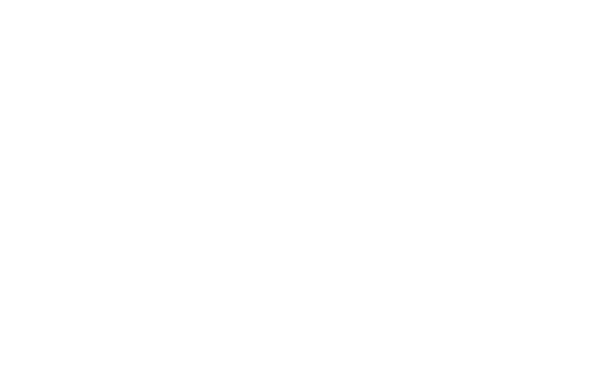

<IPython.core.display.Javascript object>


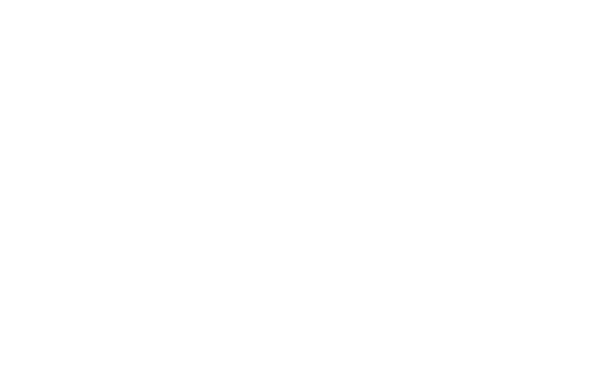

Trial 0000 status: SUCCESS


<IPython.core.display.Javascript object>


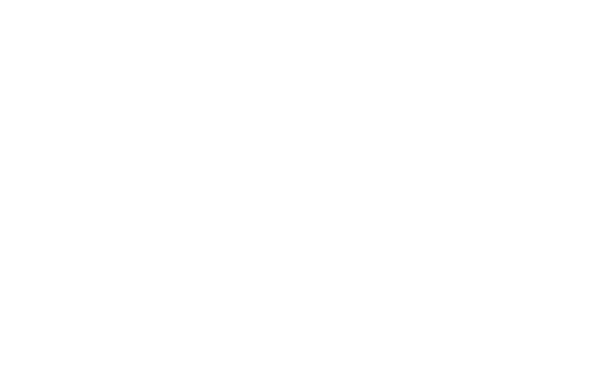

<IPython.core.display.Javascript object>


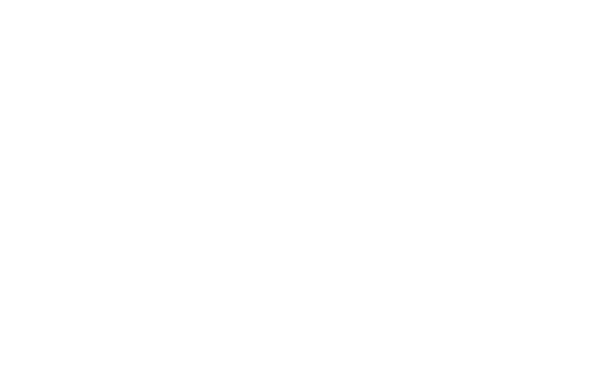

Trial 0001 status: SUCCESS
Done With Tests


In [31]:
trials_dict =  run_tests(constant_params, testing_params, param_order, param_lists)

In [32]:
# current_scale=1, env_name="no_current", eps=0.1, m=10000, rho_w=1000.0, w=5.0, l=8.0, h=2.0, C_front=0.05, C_side=0.2
# boat = create_boat(curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side)    
             
# optimize_and_plot(start, target, boat, obstacles, pad_factor, num_curr_x, num_curr_y, thrust_lim, final_tolerances, dynamics_tolerances, switches, time_interval, duration, curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side)

# OPTIMIZE AND PLOT TRAJECTORY
run_trajectory_optimization = False
if run_trajectory_optimization:
    success, states, thrusts = optimize(start, target, thrust_lim, final_tolerances, dynamics_tolerances, time_interval, duration, curr_scale, map_name, eps, m, rho_w, w, l, h, d, C_front, C_side)
     
    if animate_optimal_trajectory and success:
        x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt = states.T
        metric_times = np.linspace(0, len(x_opt)*time_interval, len(x_opt))
        animate_env(target, x_opt, y_opt, th_opt, x_dot_opt, y_dot_opt, th_dot_opt, metric_times, boat, obstacles, frame_skip=5, l=l, w=w, pad_factor=pad_factor, num_curr_x=num_curr_x, num_curr_y=num_curr_y)
        plt.figure(2)
        plot_boat_state_and_thrust(states, # plot optimization metrics
                                   thrusts,
                                   metric_times,
                                   plot=(0, 0, 0, 0, 0, 0, 1, 1), # on/off: (x, y, th_h, x_dot, y_dot, th_hdot, F_t, th_T) 
                                   normalize=True) 

# SIMULATE AND PLOT TRAJECTORY
if run_simulation:
    logger = simulate(start, [0, 0], boat, None, duration)
    x_sim, y_sim, th_sim, x_dot_sim, y_dot_sim, th_dot_sim = logger.data()[:6]
    metric_times = logger.sample_times()
    if animate_simulation:
        animate_env(x_sim, y_sim, th_sim, x_dot_sim, y_dot_sim, th_dot_sim, metric_times, boat, obstacles, frame_skip=50, l=l, w=w, pad_factor=pad_factor)
    else:
        static_plot(x_sim, y_sim, th_sim, x_dot_sim, y_dot_sim, th_dot_sim, metric_times, boat, obstacles, l, pad_factor, num_curr_x, num_curr_y, target)


NameError: name 'run_simulation' is not defined